<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/TimeSeries/StockPicker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is a simple strategy to pick a stock (or as many as stock you want)
<br><br>
Strategy explanation:<br>
To pick a stock I use 3 parameters:<br>
1- Time frame:  Period of time you make your tade and within that time you want to achive your return. For example 1 month. <br>
2- Min Return: The amount of return in percent, I expect to see one month after I buy the stock. 5% for example<br>
3- Max Volatility: The smaller this percent is less volatile stock but more conservative (less risky)<br>


---

Written by: Arjang Fahim
Date: 6/1/2022<br>
Last update: 6/8/2022

In [34]:
! pip install git+https://github.com/pydata/pandas-datareader.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-jbvurodt
  Running command git clone -q https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-jbvurodt
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev0+12.gab26ad2-py3-none-any.whl size=109746 sha256=40722707d70450e564c65c3749bd9a4d5bd8106f4b56b969b46f2c0932d26e6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-w8d4wex8/wheels/54/6a/47/b1e68c4877ae6bf9a511e84e13972507e0fac9e17335156eb7
Successfully built pandas-datareader
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader._utils import RemoteDataError
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def plot_stock_trend_and_returns(ticker, titles, start_date, end_date, all_returns):
    
    #get the data for this ticker
    prices = web.DataReader(ticker, 'yahoo', start=start_date, end=end_date).Close
    prices.index = [d.date() for d in prices.index]
    
    plt.figure(figsize=(10,6))
    
    #plot stock price
    plt.subplot(2,1,1)
    plt.plot(prices)
    plt.title(titles[0], fontsize=16)
    plt.ylabel('Price ($)', fontsize=14)
    
    #plot stock returns
    plt.subplot(2,1,2)
    plt.plot(all_returns[0], all_returns[1], color='g')
    plt.title(titles[1], fontsize=16)
    plt.ylabel('Pct. Return', fontsize=14)
    plt.axhline(0, color='k', linestyle='--')
    
    plt.tight_layout()
    
    plt.show()

In [4]:
def perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks, verbose=False):
    """
    Inputs:
        ticker: the ticker symbol to analyze
        start_date: the first date considered in simulation
        end_date: the last date considered in simulation
        return_period_weeks: the number of weeks in which to calculate returns
        verbose: True if you want to print simulation steps
        
    Outputs:
        average and standard deviation of returns for simulated runs of this ticker within the given date range
    """
    
    #get the data for this ticker
    try:
        prices = web.DataReader(ticker, 'yahoo', start=start_date, end=end_date).Close
    #could not find data on this ticker
    except (RemoteDataError, KeyError):
        #return default values
        return -np.inf, np.inf, None
    
    prices.index = [d.date() for d in prices.index]
    
    #this will store all simulated returns
    pct_return_after_period = []
    buy_dates = []

    #assume we buy the stock on each day in the range
    for buy_date, buy_price in prices.iteritems():
        #get price of the stock after given number of weeks
        sell_date = buy_date + timedelta(weeks=return_period_weeks)
        
        try:
            sell_price = prices[prices.index == sell_date].iloc[0]
        #trying to sell on a non-trading day, skip
        except IndexError:
            continue
        
        #compute the percent return
        pct_return = (sell_price - buy_price)/buy_price
        pct_return_after_period.append(pct_return)
        buy_dates.append(buy_date)
        
        if verbose:
            print('Date Buy: %s, Price Buy: %s'%(buy_date,round(buy_price,2)))
            print('Date Sell: %s, Price Sell: %s'%(sell_date,round(sell_price,2)))
            print('Return: %s%%'%round(pct_return*100,1))
            print('-------------------')
    
    #if no data collected return default values
    if len(pct_return_after_period) == 0:
        return -np.inf, np.inf, None
    
    #report average and deviation of the percent returns
    return np.mean(pct_return_after_period), np.std(pct_return_after_period), [buy_dates, pct_return_after_period]

# **User Input Data**

In [5]:
#start date for simulation. 
#Further back means more training data but risk of including patterns that no longer exist
#More recent means less training data but only using recent patterns
#start_date, end_date = datetime(2022,5,8), datetime.now().date()
start_date, end_date = datetime(2020,4,1), datetime(2020,9,1)

#set number of weeks in which you want to see return
return_period_weeks = 4

#I want at least this much average return
min_avg_return  = 0.1
#min_avg_return  = 0.05

#I want at most this much volatility in return
max_dev_return = 0.07
#max_dev_return = 0.09

In [6]:
#Download file "series_tickers.p" from github or create your own list of tickers
series_tickers = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TimeSeries/data/series_tickers.p", "rb" ))

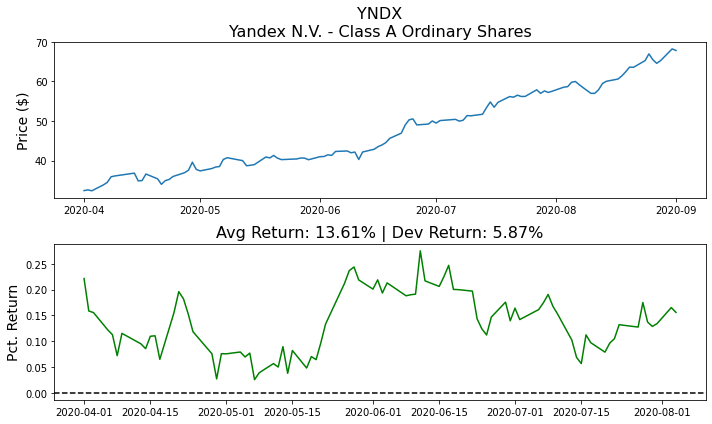

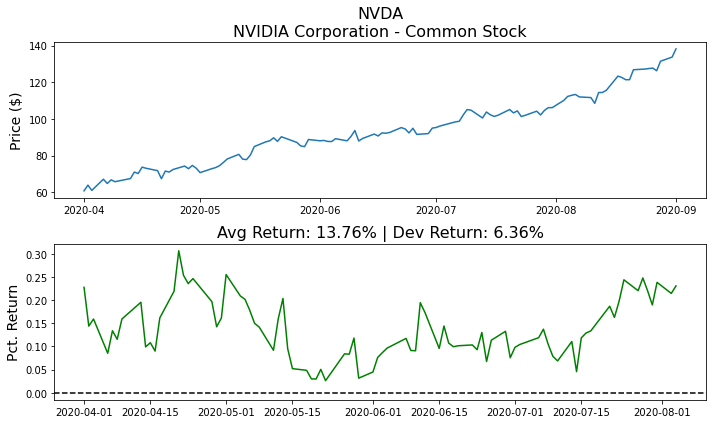

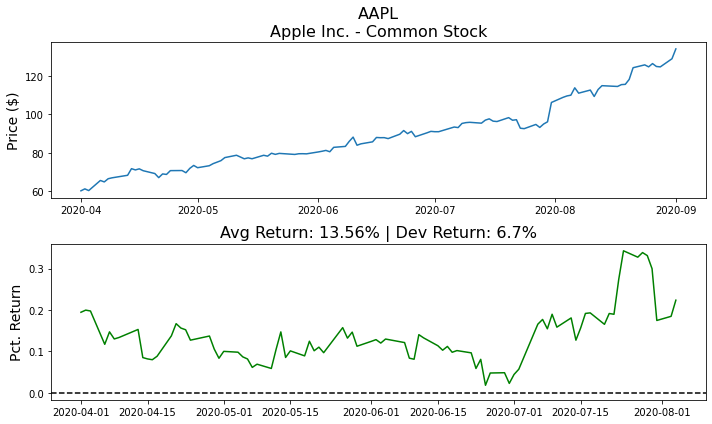

In [13]:
for ticker, name in series_tickers.iteritems():
    avg_return, dev_return, all_returns = perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks)
    
    if avg_return > min_avg_return and dev_return < max_dev_return:
        title_price = '%s\n%s'%(ticker, name)
        title_return = 'Avg Return: %s%% | Dev Return: %s%%'%(round(100*avg_return,2), round(100*dev_return,2))
        plot_stock_trend_and_returns(ticker, [title_price, title_return], start_date, end_date, all_returns)